This notebook applies hierarchical bayesian modeling using topographical remote sensing product

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
import pymc3 as pm
from tqdm import tqdm
from sklearn.metrics import *
import numpy as np

from src.utils import *
from src.params import *
tqdm.pandas()

from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


# Data Pre-Processing

In [3]:
df, basin_idx, basins, coords = read_data(file_dir='../data/hierarchical_septics_v5.csv',
        cols=['ppt_2021', 'hydraulic_c','median_hse', 'dem'], is_balanced=True)

/Users/juannat/Documents/research/septic/bayesian_septic/notebooks/../src/utils.py:76: DtypeWarning: Columns (8,11,13,15,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_dir)


balancing...
repairs: 27.73092578545258%, non-repairs: 72.26907421454743%


# VIF Analysis

In [4]:
vif_data = pd.DataFrame()
cluster_var = ['ppt_2021_norm', 'hydraulic_c_norm', 'median_hse_norm', 'dem_norm']
X = df[cluster_var]
vif_data['feature'] = cluster_var
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(cluster_var))]

In [5]:
vif_data

,feature,VIF
0,ppt_2021_norm,1.136682
1,hydraulic_c_norm,1.611612
2,median_hse_norm,1.238910
3,dem_norm,1.764298


# Hierarchical Bayesian Model

- Group septic systems based on their basin (~1560 basins)
- The effect of precipitation, distance to water bodies, soil characteristic, housing, topography to septic's status

The new variable, flow accumulation or DEM ($f$):

$$
\begin{align}
    \textbf{Flow or DEM parameters}\\
    \beta_{f,k} \sim \Gamma_{f,k}(\alpha = \alpha_f, \beta=\beta_f)\\
    \alpha_f \sim HN_f(\sigma=1)\\
    \beta_f \sim HN_f(\sigma=5)\\
\end{align}
$$

\begin{equation*}
Y_{i} \sim Bernoulli(\theta_{i})\tag{1}
\end{equation*}

\begin{equation*}
\theta_{i} = \sigma(\beta_{c,i} + \beta_{w,i}.waterdist + \beta_{p,i}.precip + \beta_{h,i}.hydraulics + \beta_{s,i}.hseval + \beta_{t,i}.elev) \tag{2}
\end{equation*}

\begin{equation*}
\textbf{Intercept parameters}\\
    \beta_{c,i} \sim N_{c,i}(\mu=\mu_{c}, \sigma=\theta_{c})\\
    \text{where }\mu_{c} \sim N_c(\mu=0, \sigma=10) \quad and \quad \theta_{c} \sim HN_c(\sigma=10) \tag{3}
\end{equation*}

\begin{equation*}
\textbf{Water distance parameters}\\
    \beta_{w,i} \sim Exp_{w,i}(\sigma=\sigma_w)\\
    \text{where }\quad \sigma_w \sim HN_p(\sigma=10) \tag{4}
\end{equation*}

\begin{equation*}
\textbf{Precipitation parameters}\\
    \beta_{p,i} \sim N_{p,i}(\mu=\mu_{p}, \sigma=\sigma_p)\\
    \text{where }\mu_{p} \sim N_p(\mu=0, \sigma=10) \quad and \quad \sigma_p \sim HN_p(\sigma=10) \tag{4}
\end{equation*}

\begin{equation*}
\textbf{Soil hydraulic conductivity parameters}\\
    \beta_{h,i} \sim N_{h,i}(\mu=\mu_{h},\sigma=\sigma_h)\\
    \text{where }\mu_{h} \sim N_h(\mu=0, \sigma=10) \quad and \quad \sigma_h \sim HN_h(\sigma=10) \tag{5}
\end{equation*}

\begin{equation*}
\textbf{Socio-economic parameters}\\
    \beta_{s,i} \sim N_{s,i}(\mu=0, \sigma=\sigma_s)\\
    \text{where }\sigma_s \sim HN_s(\sigma=10) \tag{6}
\end{equation*}

\begin{equation*}
\textbf{Topography (elevation) parameters}\\
    \beta_{t,i} \sim Exp_{t,i}(\lambda=\lambda_t)\\
    \text{where }\lambda_t \sim HN_t(\sigma=10) \tag{7}
\end{equation*}

In [6]:
rs = 100
tune = 100

1. Water model: precipitation and distance to water bodies

In [7]:
# Modeling (water)
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx, dims='septic')
    # water_d = pm.Data('water_d', df.water_dist_norm.values, dims='septic')
    ppt_d = pm.Data('ppt_d', df.ppt_2021_norm.values, dims='septic')

    # global model parameters
    # wtr_beta = pm.HalfNormal('wtr_beta', sigma=10)
    ppt_mu = pm.Normal('ppt_mu', mu=0, sigma=10)
    ppt_sig = pm.HalfNormal('ppt_sig', sigma=10)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    # wtr_dist = pm.Exponential('wtr_dist', lam=wtr_beta, dims='basin')
    ppt = pm.Normal('ppt', mu=ppt_mu, sigma=ppt_sig, dims='basin')
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, dims='basin')
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin] 
                                    # + wtr_dist[basin] * water_d 
                                    + ppt[basin] * ppt_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(100, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [c, ppt, sigma_c, mu_c, ppt_sig, ppt_mu]


/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 100 tune and 100 draw iterations (300 + 300 draws total) took 1597 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


In [8]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

accuracy is: 68.4739123518651 ± 0.019289923992298754%


2. Soil model

In [9]:
# Modeling (soil)
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx, dims='septic')
    hydr_d = pm.Data('hydr_d', df.hydraulic_c_norm.values, dims='septic')

    # global model parameters
    hydr_mu = pm.Normal('hydr_mu', mu=0, sigma=10)
    hydr_sig = pm.HalfNormal('hydr_sig', sigma=10)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    hydr = pm.Normal('hydr', mu=hydr_mu, sigma=hydr_sig, dims='basin')
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, dims='basin')
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin] 
                                    + hydr[basin] * hydr_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(100, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [c, hydr, sigma_c, mu_c, hydr_sig, hydr_mu]


/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 100 tune and 100 draw iterations (300 + 300 draws total) took 1608 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


In [10]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

accuracy is: 68.44637318062516 ± 0.013089422725778998%


3. Topo model: elevation

In [11]:
# Modeling (topo)
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx, dims='septic')
    dem_d = pm.Data('dem_d', df.dem_norm.values, dims='septic')

    # global model parameters
    dem_beta = pm.HalfNormal('dem_beta', sigma=10)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    dem = pm.Exponential('dem', lam=dem_beta, dims='basin')
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, dims='basin')
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin] 
                                    + dem[basin] * dem_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(100, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [c, dem, sigma_c, mu_c, dem_beta]


/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 100 tune and 100 draw iterations (300 + 300 draws total) took 2643 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9697828066814971, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedep

In [12]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

accuracy is: 68.21015270818421 ± 0.023924775978691457%


4. Socio-economic model: median housing value

In [13]:
# Modeling (socio)
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx, dims='septic')
    hse_d = pm.Data('hse_d', df.median_hse_norm.values, dims='septic')

    # global model parameters
    hse_sig = pm.HalfNormal('hse_sig', sigma=10)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    hse = pm.Normal('hse', mu=0, sigma=hse_sig, dims='basin')
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, dims='basin')
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin] 
                                    + hse[basin] * hse_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(100, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [c, hse, sigma_c, mu_c, hse_sig]


/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 100 tune and 100 draw iterations (300 + 300 draws total) took 1587 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


In [14]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

accuracy is: 68.67901455499882 ± 0.04525537469142099%


5. Full model

In [15]:
# Modeling (full)
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx, dims='septic')
    # water_d = pm.Data('water_d', df.water_dist_norm.values, dims='septic')
    ppt_d = pm.Data('ppt_d', df.ppt_2021_norm.values, dims='septic')
    hydr_d = pm.Data('hydr_d', df.hydraulic_c_norm.values, dims='septic')
    hse_d = pm.Data('hse_d', df.median_hse_norm.values, dims='septic')
    dem_d = pm.Data('dem_d', df.dem_norm.values, dims='septic')

    # global model parameters
    # wtr_beta = pm.HalfNormal('wtr_beta', sigma=10)
    ppt_mu = pm.Normal('ppt_mu', mu=0, sigma=10)
    ppt_sig = pm.HalfNormal('ppt_sig', sigma=10)
    hydr_mu = pm.Normal('hydr_mu', mu=0, sigma=10)
    hydr_sig = pm.HalfNormal('hydr_sig', sigma=10)
    hse_sig = pm.HalfNormal('hse_sig', sigma=10)
    dem_beta = pm.HalfNormal('dem_beta', sigma=10)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    # wtr_dist = pm.Exponential('wtr_dist', lam=wtr_beta, dims='basin')
    ppt = pm.Normal('ppt', mu=ppt_mu, sigma=ppt_sig, dims='basin')
    hydr = pm.Normal('hydr', mu=hydr_mu, sigma=hydr_sig, dims='basin')
    hse = pm.Normal('hse', mu=0, sigma=hse_sig, dims='basin')
    dem = pm.Exponential('dem', lam=dem_beta, dims='basin')
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, dims='basin')
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin] 
                                    # + wtr_dist[basin] * water_d 
                                    + ppt[basin] * ppt_d
                                    + hydr[basin] * hydr_d
                                    + hse[basin] * hse_d
                                    + dem[basin] * dem_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(100, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [c, dem, hse, hydr, ppt, sigma_c, mu_c, dem_beta, hse_sig, hydr_sig, hydr_mu, ppt_sig, ppt_mu]


/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 100 tune and 100 draw iterations (300 + 300 draws total) took 3964 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9708668395100559, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedep

In [16]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

accuracy is: 69.64566929133858 ± 0.013859647879266388%


In [17]:
graph = pm.model_graph.model_to_graphviz(model)
graph.render(filename='../docs/single_level')

'../docs/single_level.pdf'

# Evaluation

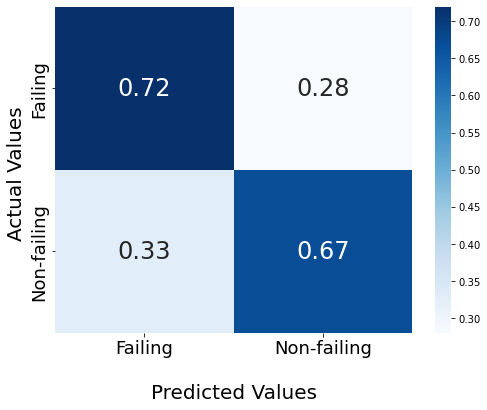

In [18]:
plot_confusion(y, y_pred, title='', savedir='../docs/confusion_l1.pdf')

In [19]:
# Get all learned parameters
hier_post = trace.posterior.stack(chain_draw=("chain", "draw"))

learned_params = dict()
learned_params.update({
    'c': hier_post['c'].mean().item(),
    'ppt': hier_post['ppt'].mean().item(),
    'hydr': hier_post['hydr'].mean().item(),
    'hse': hier_post['hse'].mean().item(),
    'dem': hier_post['dem'].mean().item()
})

learned_params

{'c': 0.045028110893541154,
 'ppt': -0.07455693046487485,
 'hydr': 0.013085501406155935,
 'hse': -0.04829103998956482,
 'dem': 0.5614131200375277}

## Posterior Variance Check

In [20]:
with model:
    ppc = pm.sample_posterior_predictive(
        trace, var_names=['ppt', 'hydr', 'hse', 'dem', 'failures']
    )

In [21]:
# Compute aprior and fitted posterior SD
var_dict = {'ppt': 10, 'hydr': 10, 'hse': 10, 'dem': 10}
post_init_var = []
post_fit_var = []
for param, var in var_dict.items():
    # post_init_var.append(round(np.sqrt(full_priors[param].var()), 2))
    post_init_var.append(var_dict[param])
    post_fit_var.append(round(np.sqrt(ppc[param].var()), 2))

init_var_df = pd.DataFrame({'Params': var_dict.keys(), 'SD': post_init_var, 'Parameter': 'Prior'})
fit_sig_df = pd.DataFrame({'Params': var_dict.keys(), 'SD': post_fit_var, 'Parameter': 'Fitted'})

sig_df = pd.concat([init_var_df, fit_sig_df])

/var/folders/3_/bdv8r_590xz8hvrnflbd7dxm0000gn/T/ipykernel_3548/1279561997.py:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inces" which is no longer supported as of 3.3 and will become an error in 3.6
  f.savefig('../docs/posterior_var.pdf', dpi=300, bbox_inces='tight')


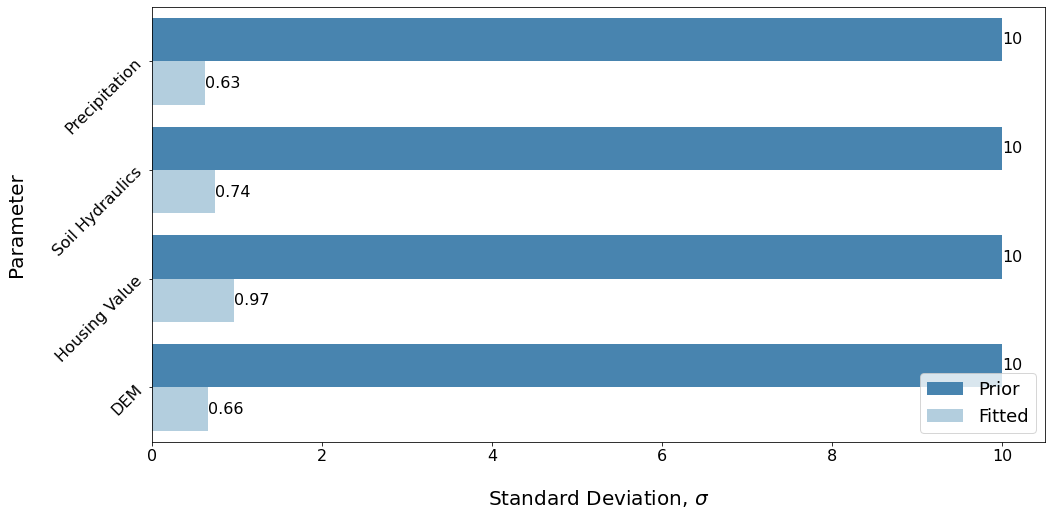

In [22]:
# Plotting
f, ax = plt.subplots(figsize=(16, 8))
ax = sns.barplot(x='SD', y='Params', hue='Parameter', data=sig_df, palette='Blues_r', orient='h')
# ax.set_title('SD for Priori and Fitted Posterior', size=16)
ax.set_xlabel('Standard Deviation, $\sigma$', labelpad = 24, fontsize=20)
ax.set_ylabel('Parameter', labelpad = 24, fontsize=20)
labels = ['Precipitation', 'Soil Hydraulics', 'Housing Value', 'DEM']
ax.set_yticklabels(labels)
ax.tick_params(labelsize=16)
plt.legend(fontsize=18, loc='lower right')
plt.yticks(rotation = 45)
for i in ax.containers:
    ax.bar_label(i,size=16)

f.savefig('../docs/posterior_var.pdf', dpi=300, bbox_inces='tight')